<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">THE MECHANICS OF PYTORCH</h1><br>

<br><br><font color='darkpink'>Notations : PyTorch, alike TensorFlow and other IT libraries, does not use the more natural notations found in mathematical texts or usual DL diagrams : in any layer, the rows, not the columns, represent the images of the input instances.</font>

<br/><div style="font-family: Arial; color: darkblue; font-size: 16; font-weight: 600; "><a id="toc"></a>
In this part 13:
    <p style="margin: 0 0 0 2rem; font-weight: 800">[1. Automatic differentiation](#1)</p>
        <p style="margin: 0 0 0 4rem; font-size: 14">[1a. Computational graphs](#1a)</p>
        <p style="margin: 0 0 0 4rem; font-size: 14">[1b. Computing gradients via automatic differentiation](#1b)</p>
    <p style="margin: 0 0 0 2rem; font-weight: 800">[2. The various ways to define a layer](#2)</p>
        <p style="margin: 0 0 0 4rem; font-size: 14">[2a. The XOR classification problem](#2a)</p>
        <p style="margin: 0 0 0 4rem; font-size: 14">[2b. Writing layers with torch.nn.Sequential](#2b)</p>
        <p style="margin: 0 0 0 4rem; font-size: 14">[2c. Writing layers with torch.nn.Module](#2c)</p>
        <p style="margin: 0 0 0 4rem; font-size: 14">[2d. Writing custom layers](#2d)</p>
    <p style="margin: 0 0 0 2rem; font-weight: 800">[3. Regression project - Fuel efficiency of a car](#3)</p>
        <p style="margin: 0 0 0 4rem; font-size: 14">[3a. Preprocess the feature columns](#3a)</p>
        <p style="margin: 0 0 0 4rem; font-size: 14">[3b. The model and its predictions](#3b)</p>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from colorama import Fore, Back, Style
# define some strings for cleaner codes
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT
GB = Fore.GREEN + Style.BRIGHT

<a id="1"></a><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. AUTOMATIC DIFFERENTIATION</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1a. Computational graphs</font><a id="1a"></a></p>$\quad$
        A <font color='darkpink'>computational graph</font> (or <font color='darkpink'>computation graph</font>) is a graph where the roots are the inputs and the leaves are the outputs of some computation, and each node represents a single operation within the computation. For example if the inputs are $a$, $b$ and $c$ and the output is $z=2*(a-b)+c$, then the first node will be the child of $a$ and $b$ with the content $r_1 = a-b$, the second node will be the child of this node with the content $r_2 = 2*r_1$, and the leaf will be a child of this node and the root containing $c$, with the content $z = r_2+c$. Let's see a representation of this graph :

<figure style="text-align: center;">
    <img src="13.1. A computational graph.png" alt="Figure showing the graph we have just described." width="350" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">A computational graph</figcaption>
</figure>

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In PyTorch, computational graphs are used to compute the differentials of the weights and biases through backpropagation; they are made on the fly during the forward pass, and deleted at the end of the backward pass; we speak of <font color='darkpink'>dynamic graphs</font>, as opposed to <font color='darkpink'>static graphs</font>, which are built once before the training phase and reused throughout, making them more efficient but less flexible for dynamic computation : with dynamic graphs we can change the shape, size and operations at each iteration if needed.

<br><br><div style="font-family: Arial; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1b. Computing gradients via automatic differentiation</font><a id="1b"></a></p>
    <p style="margin: 0; font-size: 14px; font-weight: 500">$\quad$
        Suppose that, after the previous computations, we apply a function $f$ to $z$, whether an activation function or a loss function, and that we want to compute the derivative of $f(z)$ with respect to $a$, for example to update $a$ when it is a parameter. Then, according to the chain rule, we have<font color='darkpink'>
    $$\frac{\partial f}{\partial a} \;=\; \frac{\partial f}{\partial z} \, \frac{\partial z}{\partial r_2} \, \frac{\partial r_2}{\partial r_1} \, \frac{\partial r_1}{\partial a} \,\qquad (1)$$</font>$\quad$
        PyTorch knows the derivatives of all the activation functions and all the loss functions that it proposes to its users, as well as the derivatives of the simple (affine) computations, so it can compute the derivative of $f$ with respect to $a$.<br>$\quad$
        More generally, we begin by telling PyTorch which are the parameters we are interested in updating (the weights and biases); this is done by using the <font color='darkred'>requires_grad=True</font> argument when initializing the parameters, or using the <font color='darkred'>.requires_grad_()</font> method afterwards. Then, when running the model, PyTorch will build the computational graph from these parameters up to the cost function during the forward pass; while doing so, in each node it saves the result of the operation performed at the node, as well as the derivative of the operation. Once the computational graph is built, when we call <font color='darkred'>loss.backward()</font>, PyTorch can start from the derivative of the <font color='darkred'>loss</font> function (which is considered to be the root), multiply it in each node of the last layer by the appropriate derivative; when this derivative is with respect to a parameter it has reached a leaf and it stores the result in this leaf; then, PyTorch can go to the previous layer, and so on, until it reaches the first layer; at this point, the derivative of the loss with respect to a parameter is in the root corresponding to this parameter (we may then access the value of the derivative of any parameter, say $w$, by calling its <font color='darkred'>.grad</font> attribute, here <font color='darkred'>$w$.grad</font>). PyTorch is then able to update the parameter according to the chosen <font color='darkred'>optimizer</font>; we just need to call <font color='darkred'>optimizer.step()</font>.<br>$\quad$
        If we don't need to perform a backward pass after a forward pass (eg when applying our model to a test dataset), or if updating a tensor $z$ is no longer needed, then it will be more efficient to tell PyTorch to stop tracking the parameters' derivatives, or to stop tracking $z$'s derivative. This is done by the instructions <font color='darkred'>with torch.no_grad() :</font> and <font color='darkred'>z.detach()</font> respectively.

<a id="2"></a><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. THE VARIOUS WAYS TO DEFINE LAYERS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2a. The XOR classification problem</font><a id="2a"></a></p>$\quad$
        We will illustrate the various ways to define the layers of a model with the study of the classic <font color='darkpink'>XOR classification problem</font>. It is a classic problem for analyzing the capacity of a model with regard to capturing the nonlinear decision boundary between two classes.<br>$\quad$
        We generate a toy dataset of $200$ training examples with two features, $x_0$ and $x_1$, drawn from a uniform distribution over $[-1; 1[$. Then, we assign the <font color='darkpink'>ground truth label</font> for the instance $i$ according to the following rule :<font color='darkpink'>
    $$y^{(i)} \;=\; \begin{cases} 0 & \mbox{if } x^{(i)}_0 \, x^{(i)}_1 < 0 \\ 1 & \mbox{otherwise} \end{cases} \,\qquad (2)$$</font>$\quad$
    We will use half of the data ($100$ training examples) for training and the remaining half for validation.
The code for generating the data and splitting it into the training and validation datasets is as follows; we added some lines of code to represent the data in a diagram (the elements of class $0$ - resp. $1$ - are represented by the blue disks - violet triangles -) :

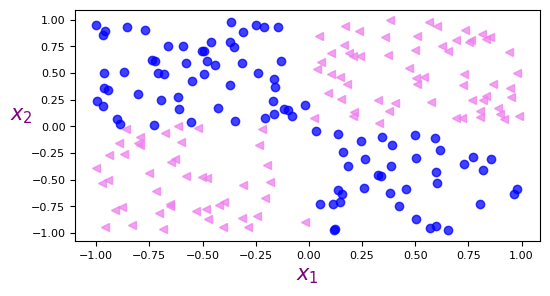

In [2]:
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 3))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=6, color="blue")
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=6, color="violet")
plt.tick_params(axis='both', labelsize=8)
plt.xlabel(r'$x_1$', size=15, color="purple")
plt.ylabel(r'$x_2$  ', rotation=0, size=15, color="purple")
plt.show()

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can convert our NumPy dataset into a PyTorch dataset with the <font color='green'>TensorDataset(input_features, labels)</font> class, introduced in the previous part, "3a. torch.nn, the PyTorch NN module". And then create a companion dataloader with the <font color='green'>DataLoader(dataset, batch_size=1, shuffle=False, drop_last=False)</font> class, introduced in the previous part, "2a. Creating a DataLoader from existing tensors"; we choose a batch size of $2$ :

In [3]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        To study this dataset, we will implement various models, but we will use the same loss function, the same optimizer, and the same training algorithm.<br>$\quad$
        Our loss function will be the <font color='darkpink'>Binary Cross Entropy</font>, which is used for binary classification tasks when its inputs (ie the outputs of the model) are probabilities (usually obtained from a sigmoid activation : if an instance $x$ has a preactivation $z$ on the last layer, then $x$ will be predicted to belong to class $1$ with a probability of $\sigma(z)$, and to class $0$ with a probability of $1\!-\!\sigma(z)$).<br>
    It is implemented in PyTorch as <font color='green'>torch.nn.BCELoss(weight=None, reduction='mean')</font>, which is defined as follows. If we have a set of examples $x = \left(x^{(i)}\right)_{i=1}^m$ with true targets $y = \left(y^{(i)}\right)_{i=1}^m$ and predicted probabilities $\hat{y} = \left(\hat{y}^{(i)}\right)_{i=1}^m$ that they belong to the positive class (class $1$) , and if its weight for the Binary Cross Entropy loss is $\gamma = \left(\gamma_i\right)_{i=1}^m$, then we define the <font color='purple'>unreduced Binary Cross Entropy</font> as the column vector $\left(l^{(i)}\right)_{i=1}^m$ where for any $i$ we have<font color='purple'>
    $$l^{(i)} \;=\; -\, \gamma_i \, \left[y^{(i)} \, \ln\left(\hat{y}^{(i)}\right) \,+\, \left(1\!-\!y^{(i)}\right) \, \ln\left(1\!-\!\hat{y}^{(i)}\right)\right] \,\qquad (3)$$</font>
    <font color='green'>torch.nn.BCELoss(weight=$\gamma$, reduction='none')</font> is the Binary Cross Entropy with weight $\gamma$; <font color='green'>torch.nn.BCELoss(weight=$\gamma$, reduction='sum')</font> is the sum $\sum_{i=1}^m \, l^{(i)}$, and <font color='green'>torch.nn.BCELoss(weight=$\gamma$, reduction='mean')</font> is the mean<font color='purple'>
    $$\mathcal{L}\left(\hat{y},y\right) \;=\; - \frac{1}{m} \, \sum_{i=1}^m \, \gamma_i \, \left[y^{(i)} \, \ln\left(\hat{y}^{(i)}\right) \,+\, \left(1\!-\!y^{(i)}\right) \, \ln\left(1\!-\!\hat{y}^{(i)}\right)\right] \,\qquad (4)$$</font>
    The default for <font color='green'>reduction</font> is <font color='green'>reduction='mean'</font>, and the default for <font color='green'>weight</font> is <font color='green'>weight=None</font>, which corresponds to a weight $\gamma$ whose components are all equal to $1$.

<p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Our optimizer will be the SGD, which has been presented in our previous part, "3b. Linear regression with torch.nn and torch.optim". We will only use the arguments <font color='green'>torch.optim.SGD(params, lr=0.001)</font>, with the parameters to update <font color='darkred'>params = model.parameters()</font> and the learning rate <font color='darkred'>lr=$0.001$</font>.<br>
    Hence to define our optimizer we need to define a model. We also need a model to code our training algorithm. So let's define the simplest of models; we will explain it in the next subchapter. And then present our training algorithm for this chapter. So, our first model will be :

In [4]:
model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())

<p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Our loss function and our optimizer will be :

In [5]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

<p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        And our training algorithm will be :

train accuracy : tensor(0.6400)
validation accuracy : tensor(0.7100)


Text(0.5, 0, 'Epochs')

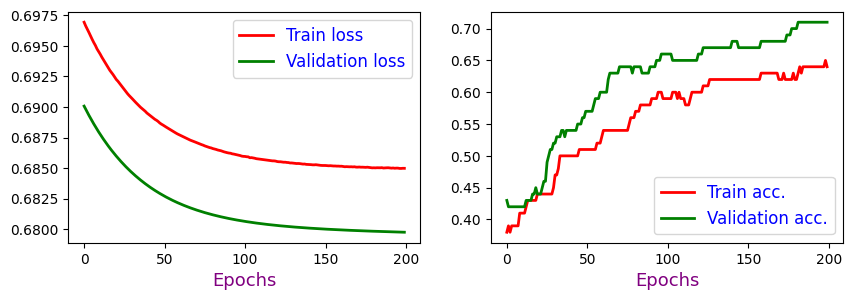

In [6]:
torch.manual_seed(1)
n_epochs = 200

def train(model, n_epochs, train_dl, x_valid, y_valid):
    # creates a list of length 'n_epochs' whose components are all equal to 0
    loss_hist_train = [0] * n_epochs
    accuracy_hist_train = [0] * n_epochs
    loss_hist_valid = [0] * n_epochs
    accuracy_hist_valid = [0] * n_epochs
    for epoch in range(n_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            # backpropagates to compute the gradients of the loss with respect to the model's parameters
            loss.backward()
            # updates the model's parameters using the computed gradients and the optimizer
            optimizer.step()
            # resets the gradients to None, preventing gradients from accumulating additively across
            # multiple iterations, which is the default behavior
            optimizer.zero_grad()
            # accumulates the loss for the current batch
            loss_hist_train[epoch] += loss.item()
            # builds a tensor of length 2 (batch_size); a component is 1. if the true label is predicted,
            # 0. otherwise ('.float()' converts the boolean resulting from the '==' test into a float)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, n_epochs, train_dl, x_valid, y_valid)
print(BB + "train accuracy :" + MB, history[2][-1])
print(BB + "validation accuracy :" + MB, history[3][-1])
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=2, color="red")
plt.plot(history[1], lw=2, color="green")
plt.legend(['Train loss', 'Validation loss'], fontsize=12, labelcolor="blue")
ax.set_xlabel('Epochs', size=13, color="purple")
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=2, color="red")
plt.plot(history[3], lw=2, color="green")
plt.legend(['Train acc.', 'Validation acc.'], fontsize=12, labelcolor="blue")
ax.set_xlabel('Epochs', size=13, color="purple")

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can see that our model with a single layer (defined in cell 4) is unable to solve the XOR problem satisfactorily. This was expected : a linear regression model cannot fit a non-linear boundary.<br>$\quad$
        The <font color='darkpink'>universal approximation theorem</font> states that any continuous function between finite $\mathbb{R}$-vector spaces, say from $\mathbb{R}^n$ to $\mathbb{R}^p$, can be approximated to any desired accuracy over any compact of $\mathbb{R}^n$ by any ANN containing at least one hidden layer with a non-polynomial activation function, provided it has enough hidden neurons.<br>
    This ensures that if the inputs of a problem are related to their outputs by a continuous function, then an ANN containing at least one hidden layer with a non-polynomial activation function will be able to approximate this continuous function on our dataset as closely as desired : we only need to provide it with enough neurons.<br>
    In practice, rather than using a single layer with many neurons, several layers with fewer neurons will generally be more efficient. Making a model <font color='darkpink'>deeper</font> (ie with more layers) rather than <font color='darkpink'>wider</font> (ie with more neurons in each layer) allows us to achieve a comparable model capacity with fewer parameters. However, a downside of deep (versus wide) models is that deep models are prone to vanishing and exploding gradients, which make them harder to train.<br>$\quad$
        So, now, let's see the various ways to define layers :

<br><br><div style="font-family: Arial; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2b. Writing layers with torch.nn.Sequential</font><a id="2b"></a></p>
    <p style="margin: 0; font-size: 14px; font-weight: 500">$\quad$
        With <font color='green'>torch.nn.Sequential</font> (https://pytorch.org/docs/master/generated/torch.nn.Sequential.html#sequential), we simply need to list the layers we want to use in the order we want them from the input layer to the output layer; each layer will be built upon its predecessor, in a cascading way. For example, below we build a model with three layers; the two hidden layers have a ReLU activation, and the output has the sigmoid activation, since we want our loss function to be the Binary Cross Entropy again.<br>$\quad$
        We may initialize the weights of the layers we want. Here, I have initialized the weights differently than what the book does : for one, I have initialized all the weights, rather than only the weights of the first layer, because the Xavier distributions tend to work well for all layers in ANN architectures; and I have used the Xavier normal distribution, rather than the Xavier uniform distribution, because it is what is recommended for ReLU layers.<br>$\quad$
        Also, I needed to adjust the learning rate; for our model, the book uses a learning rate of $0.015$ instead of the $0.001$ of our first model; with the initializations I chose, the results are better and they improve further with a learning rate of $0.03$.

train accuracy : tensor(1.)
validation accuracy : tensor(0.9700)


Text(0, 0.5, 'Accuracy')

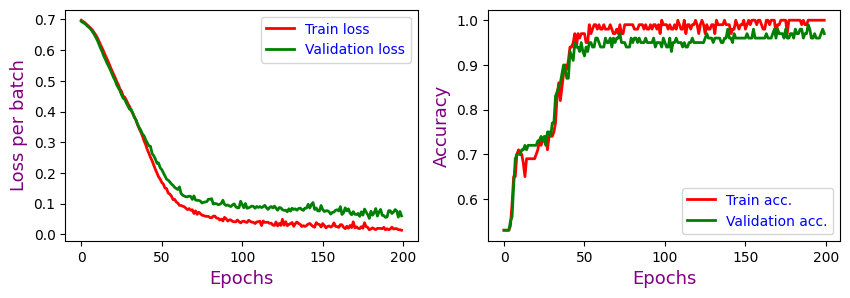

In [7]:
model_seq = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid())

torch.manual_seed(1)
nn.init.xavier_normal_(model_seq[0].weight)
nn.init.xavier_normal_(model_seq[2].weight)

optimizer = torch.optim.SGD(model_seq.parameters(), lr=0.03)

history_seq = train(model_seq, n_epochs, train_dl, x_valid, y_valid)
print(BB + "train accuracy :" + MB, history_seq[2][-1])
print(BB + "validation accuracy :" + MB, history_seq[3][-1])
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history_seq[0], lw=2, color='red')
plt.plot(history_seq[1], lw=2, color='green')
plt.legend(["Train loss", "Validation loss"], fontsize=10, labelcolor='blue')
ax.set_xlabel("Epochs", size=13, color='purple')
ax.set_ylabel("Loss per batch", fontsize=13, color='purple')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history_seq[2], lw=2, color='red')
plt.plot(history_seq[3], lw=2, color='green')
plt.legend(["Train acc.", "Validation acc."], fontsize=10, labelcolor='blue')
ax.set_xlabel("Epochs", size=13, color='purple')
ax.set_ylabel("Accuracy", fontsize=13, color='purple')

<br><br><div style="font-family: Arial; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2c. Writing layers with torch.nn.Module</font><a id="2c"></a></p>
    <p style="margin: 0; font-size: 14px; font-weight: 500">$\quad$
        In the previous subchapter, we used the PyTorch <font color='green'>nn.Sequential</font> class to create a fully connected NN with multiple layers. This is a very common and convenient way of building models. However, it only allows us to create models where the input of a layer is the output of the previous layer; for example we cannot use the output of an earlier layer, like we would do in a RNN (see part 15). That’s where <font color='green'>nn.Module</font> comes in handy.<br>$\quad$
        This time we declare our model as a subclass of <font color='green'>nn.Module</font>. We define our layers in the <font color='green'>\_\_init__</font> method, and explain how the input of each layer should be obtained from the previous outputs or initial input in the <font color='green'>forward</font> method. Note that <font color='darkpink'>the prediction of a tensor <font color='darkred'>$x$</font> by a model <font color='darkred'>model</font> is computed via <font color='darkred'>model($x$)</font>, not via <font color='darkred'>model.forward(x)</font></font>.<br>$\quad$
        We will use <font color='green'>nn.Module</font> in the following parts of this course. Here, let's simply rewrite our previous model. We add a <font color='darkred'>predict</font> method in order to draw the boundaries cut by our model (via <font color='darkred'>plot_decision_regions</font>) :

In [8]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 4)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x):
        # Apply layers one after another
        x_l1 = self.l1(x)
        x_a1 = self.a1(x_l1)
        x_l2 = self.l2(x_a1)
        x_a2 = self.a2(x_l2)
        x_l3 = self.l3(x_a2)
        x_a3 = self.a3(x_l3)
        return x_a3

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        And now we can declare one instance of our model; initialize the weights (and biases) of its linear layers; define our optimizer; train our model; and present the results. These results are very similar to the previous ones, since, ideally, they should be the same :

train accuracy : tensor(1.)
validation accuracy : tensor(0.9500)


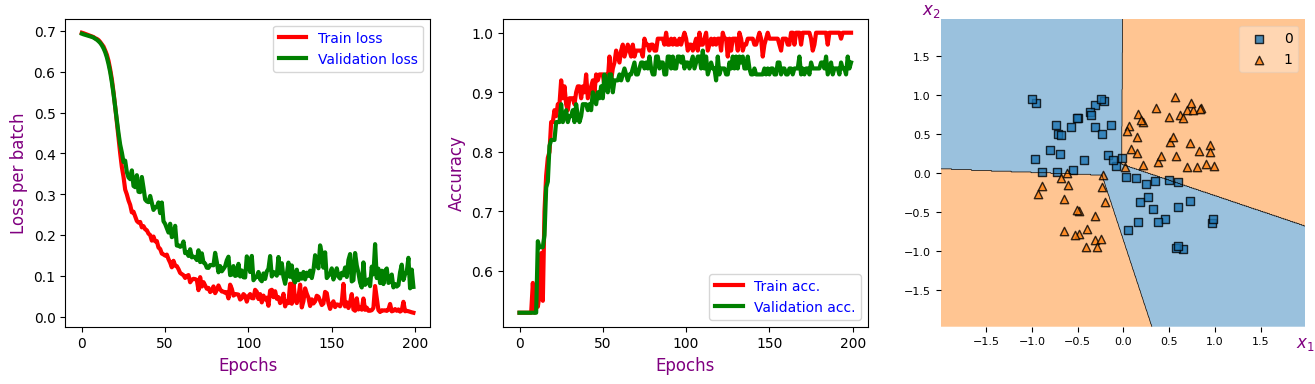

In [9]:
from mlxtend.plotting import plot_decision_regions

# initializes the model and its weights
model_mod = MyModule()
torch.manual_seed(1)
nn.init.xavier_normal_(model_mod.l1.weight)
nn.init.xavier_normal_(model_mod.l2.weight)

# ensures the biases are initialized to zero (optional)
nn.init.zeros_(model_mod.l1.bias)
nn.init.zeros_(model_mod.l2.bias)

optimizer = torch.optim.SGD(model_mod.parameters(), lr=0.03)

history_mod = train(model_mod, n_epochs, train_dl, x_valid, y_valid)

print(BB + "train accuracy :" + MB, history_mod[2][-1])
print(BB + "validation accuracy :" + MB, history_mod[3][-1])

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history_mod[0], lw=3, color='red')
plt.plot(history_mod[1], lw=3, color='green')
plt.legend(["Train loss", "Validation loss"], fontsize=10, labelcolor='blue')
ax.set_xlabel("Epochs", size=12, color='purple')
ax.set_ylabel("Loss per batch", fontsize=12, color='purple')

ax = fig.add_subplot(1, 3, 2)
plt.plot(history_mod[2], lw=3, color='red')
plt.plot(history_mod[3], lw=3, color='green')
plt.legend(["Train acc.", "Validation acc."], fontsize=10, labelcolor='blue')
ax.set_xlabel("Epochs", size=12, color='purple')
ax.set_ylabel("Accuracy", fontsize=12, color='purple')

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int32), clf=model_mod)
plt.tick_params(axis='both', labelsize=8)
plt.xlabel(r'$x_1$', size=12, color="purple")
ax.xaxis.set_label_coords(1, -0.025)
plt.ylabel(r'$x_2$', rotation=0, size=12, color="purple")
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

<br><br><div style="font-family: Arial; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2d. Writing custom layers</font><a id="2d"></a></p>
    <p style="margin: 0; font-size: 14px; font-weight: 500">$\quad$
        When we want to use a layer that is not already supported by PyTorch, we need to first define it as a subclass of <font color='green'>torch.nn.Module</font>; then we will be able to use it like any other class of our model.<br>$\quad$
        When defining our customized layer, we need to tell PyTorch which tensors are the parameters of our layer. This is done using the <font color='green'>torch.nn.parameter.Parameter(requires_grad=True)</font> class.<br>$\quad$
        As an example, let's define a layer which is a linear layer with some added noise, transforming any input tensor <font color='darkred'>$a$</font> into <font color='darkred'>$z = W\left(a+\epsilon\right) + b$</font>, where <font color='darkred'>$\epsilon$</font> is a tensor of the same size as <font color='darkred'>$a$</font> whose components are randomly chosen according to the centered normal law of a standard deviation to be specified ($0.1$ by default). Of course, this noise <font color='darkred'>$\epsilon$</font> should only be used in the training phase, not to predict the classes of the examples in the validation set; its purpose is to reduce overfitting, not to yield random guesses... We specify that we want to use a noise only during the training phase, by adding a <font color='darkred'>training</font> argument to the <font color='darkred'>forward</font> method. This implies that our <font color='darkred'>train</font> function, defined in cell 6, can no more be used, because the forward pass is not the same for the training and the validation examples; so we need to slightly modify our code :

In [10]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(output_size, input_size)
        self.w = nn.Parameter(w)
        b = torch.zeros(output_size)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev
    
    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0., self.noise_stddev, x.shape)
            x_new = x + noise
        else:
            x_new = x
        # reminder : in PyTorch layers the image of any instance is a row, not a column
        return torch.matmul(x_new, self.w.t()) + self.b

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's replace the first sub-layer of our model (the <font color='darkred'>nn.Linear(2, 4)</font>) with a <font color='darkred'>NoisyLinear(2, 4, 0.07)</font> layer. Since we added a noise, we do not initalize the weights (according to the Xavier normal distribution) like we did before. Our model with the noisy linear layer does reduce overfitting, as we hoped, and it slightly improve the predictions on the validation dataset (with an accuracy of $0.97$ instead of $0.95$) :

In [11]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
    
    def forward(self, x, training=False):
        x_l1 = self.l1(x, training)
        x_a1 = self.a1(x_l1)
        x_l2 = self.l2(x_a1)
        x_a2 = self.a2(x_l2)
        x_l3 = self.l3(x_a2)
        x_a3 = self.a3(x_l3)
        return x_a3
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()


# initializes the model
torch.manual_seed(1)
model_noi = MyNoisyModule()

train accuracy : tensor(0.9600)
validation accuracy : tensor(0.9700)


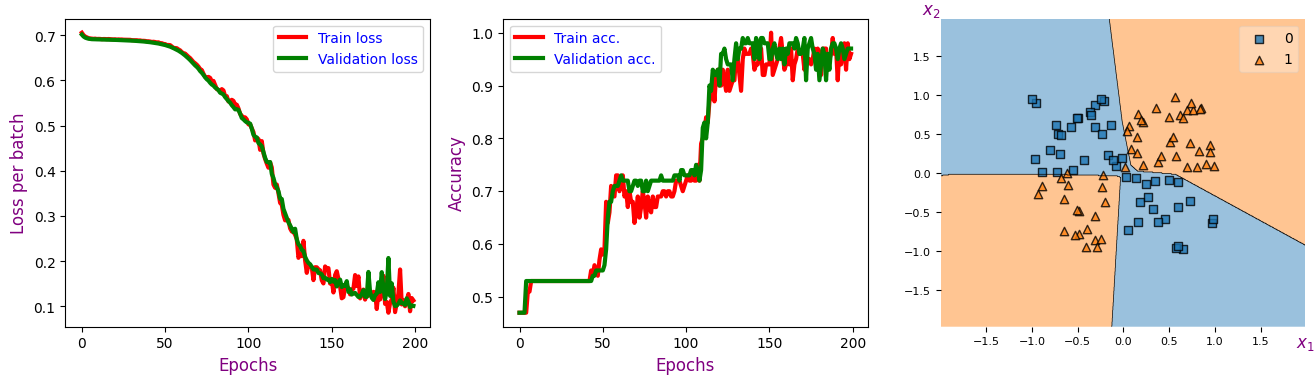

In [12]:
optimizer = torch.optim.SGD(model_noi.parameters(), lr=0.015)

loss_hist_train = [0] * n_epochs
accuracy_hist_train = [0] * n_epochs
loss_hist_valid = [0] * n_epochs
accuracy_hist_valid = [0] * n_epochs
for epoch in range(n_epochs):
    for x_batch, y_batch in train_dl:
        pred = model_noi(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train
    pred = model_noi(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

print(BB + "train accuracy :" + MB, accuracy_hist_train[-1])
print(BB + "validation accuracy :" + MB, accuracy_hist_valid[-1])

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=3, color="red")
plt.plot(loss_hist_valid, lw=3, color="green")
plt.legend(['Train loss', 'Validation loss'], fontsize=10, labelcolor="blue")
ax.set_xlabel('Epochs', size=12, color="purple")
ax.set_ylabel('Loss per batch', fontsize=12, color="purple")

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=3, color="red")
plt.plot(accuracy_hist_valid, lw=3, color="green")
plt.legend(['Train acc.', 'Validation acc.'], fontsize=10, labelcolor="blue")
ax.set_xlabel('Epochs', size=12, color="purple")
ax.set_ylabel('Accuracy', fontsize=12, color="purple")

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int32), clf=model_noi)
plt.tick_params(axis='both', labelsize=8)
plt.xlabel(r'$x_1$', size=12, color="purple")
ax.xaxis.set_label_coords(1, -0.025)
plt.ylabel(r'$x_2$', rotation=0, size=12, color="purple")
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. REGRESSION PROJECT - FUEL EFFICIENCY OF A CAR</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. Preprocess the feature columns</font><a id="3a"></a></p>$\quad$
        The goal in this project is to predict the fuel efficiency of a car in miles per gallon (MPG). As before, I will follow the plan I've proposed in the previous part, "3c. The various steps for building an ANN".<br>$\quad$
        So, the first step is to download the dataset, and to create the training Dataset and DataLoader. Here, we will use the "Auto MPG" dataset, which is a common machine learning benchmark dataset for predicting the fuel efficiency of a car in MPG. The full dataset and its description are available from UCI’s machine learning repository at https://archive.ics.uci.edu/dataset/9/auto+mpg. It is a lightweight dataset (29.5kB), so I can download it without worry for my small memory laptop; so, while the book fetched the dataset from its url each time it needs it, requiring an internet connection, I prefer to download and save it in my folder.

<p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The dataset has initially $9$ columns.<br>$\quad$
        We rename the $8$ first, via the argument <font color='green'>names=column_names</font>, where we define <font color='green'>column_names</font> as an array containing $8$ strings.<br>$\quad$
        The $9$th column contains the names of the cars' models; it is separated from the rest of the dataset by a <font color='darkred'>tab</font>; it plays no role in estimating the efficiency of a car, so we can tell pandas to discard it, via the argument <font color='green'>comment='\t'</font>.<br>$\quad$
        There are cells with an <font color='darkred'>?</font> instead of a value (eg the row corresponding to the <font color='darkred'>"ford pinto"</font> has an <font color='darkred'>?</font> for the <font color='darkred'>horsepower</font> feature). We declare these cells as <font color='darkred'>na</font> (for "not available"), and then drop the rows containing <font color='darkred'>na</font> cells from the dataset; this is done via the argument <font color='green'>na_values = "?"</font>, and then by using pandas' method <font color='green'>.dropna()</font>. Our dataframe initially had $398$ rows, and, after removal of the rows with missing data, it still has $392$ rows. Then, we reset the indexes of the dataframe to ensure there are no jumps between indexes, via pandas' method <font color='green'>.reset_index(drop=True)</font>; <font color='green'>drop=True</font> avoids adding the old index as a new column.<br>$\quad$
        The cells within a row are separated by spaces; we ask pandas to retrieve the individual values by telling it that a delimiter here is a space, via the argument <font color='green'>sep=" "</font>, and by asking it to skip potential spaces until the next non-space character, via the argument <font color='green'>skipinitialspace=True</font>. Note that a tab (which corresponds to ASCII 9) is not the same as several spaces (a space corresponds to ASCII 32), so pandas can indeed differentiate the tabs before the $9$th column from the spaces between the other columns.<br>$\quad$
        Here is the code to do all this and present the last five rows of our current dataframe :

In [13]:
import pandas as pd
local_file = 'auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year',
                'Origin']
# all arguments are explained in the presentation of the code
df = pd.read_csv(local_file, names=column_names, comment='\t', na_values = "?", sep=" ",
                 skipinitialspace=True)
print(BB + "Initial number of rows :" + MB, df.shape[0])

# drops the NA rows and resets the indexes
df = df.dropna()
df = df.reset_index(drop=True)
print(BB + "Final number of rows :" + MB, df.shape[0])

df.tail()

Initial number of rows : 398
Final number of rows : 392


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The first column (column $0$, "MPG") will be the target.<br>$\quad$
        The five following columns display numerical data; they should be standardized, because it's better for optimization, and there is no reason that differences in weight should cost more than differences in the number of cylinders.<br>$\quad$
        The last column ("Origin") displays categorical data, namely the countries where the cars were built : "$1$", "$2$" and "$3$" correspond to "USA", "Europe" and "Japan", respectively. There is no reason to consider that an American car is more different from a Japanese car than a European car would be, and another order could have been chosen. In such cases, as we did before, we replace the categories with one-hot-encoded vectors : the categories might be replaced by the vectors $[1,0,0]$, $[0,1,0]$ and $[0,0,1]$, respectively.<br>$\quad$
        As for the column $7$ ("Model Year"), although it corresponds to a numeric feature (the year the car was built), its data should be treated as a categorical data (since there is no obvious relation between the model year and the target - "MPG" -) with an order (since, a priori, efficiency has improved over time). Also, grouping cars by their year is too fine-grained, so we will define four <font color='darkpink'>buckets</font> and group our cars inside these buckets. Initially, these years go from $70$ to $82$, and our (arbitrary) buckets will be $0$, $1$, $2$ and $3$, corresponding to a year $<\!73$, in $\,[73; 76[\,$, in $\,[76, 79[\,$ and $\geq 79$, respectively.

<p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        About the implementation strategy, first note that, besides rescaling the numerical features to give them a similar cost when training a model, standardization aims to help convergence of the model, so it is done on the training dataset only, and then new samples will be transformed in the same way before using the model to get their prediction. For this we need the scikit-learn's functions <font color='green'>sklearn.model_selection.train_test_split(array, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)</font> (see below) to split the initial dataset into a training and a test dataset, and <font color='green'>sklearn.preprocessing.StandardScaler()</font>'s methods <font color='green'>.fit_transform</font> and <font color='green'>.transform</font> to fit and transform the training dataset and transform the test dataset accordingly, respectively. There are no PyTorch equivalents.<br>$\quad$
        On the other hand, the transformation of a column of categories into a column of one-hot-encoded vectors is typically done with PyTorch's function <font color='green'>torch.nn.functional.one_hot(tensor, num_classes=-1)</font> (see below), which requires the column to be first converted into a PyTorch tensor; there is no direct equivalent of this function in Numpy.<br>$\quad$
        Consequently, although it would be ideal, for conciseness of the code, to first convert our dataset into a PyTorch tensor in order to transform our categorical columns using <font color='green'>one_hot</font> and <font color='green'>torch.bucketize(input, boundaries, out_int32=False, right=False, out=None)</font> (see below), then split the dataset into a training and a test dataset, and finally standardize the training dataset and apply the same transformation to the test dataset, this is not possible because the standardization step requires the columns to be in pandas or numpy form. Instead, we need to first split our dataset into a training and a test dataset, then standardize the training dataset and apply the same transformation to the test dataset, and finally convert both datasets into PyTorch tensors, so we can apply <font color='green'>one_hot</font> and <font color='green'>bucketize</font> to them, once for each dataset instead of once for the whole initial dataset.<br>$\quad$
        Before following this strategy, let's present the functions that we will use.

<p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In order to split the initial dataset between a training and a test dataset, we will use the scikit-learn's function <font color='green'>sklearn.model_selection.train_test_split(array, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)</font>, where :<br>
    * <font color='green'>array</font> specifies the numpy array or pandas dataframe to be split<br>
    * <font color='green'>test_size</font> specifies either a float in $]0;1[$ or a positive integer less than the initial number of samples, corresponding to the proportion of initial samples or the number of initial samples to include in the test dataset. If <font color='green'>None</font>, <font color='green'>test_size</font> is set to the complement of <font color='green'>train_size</font>. If <font color='green'>train_size</font> is also <font color='green'>None</font>, it will be set to $0.25$.<br>
    * <font color='green'>train_size</font> specifies either a float in $]0;1[$ or a positive integer less than the initial number of samples, corresponding to the proportion of initial samples or the number of initial samples to include in the training dataset. If <font color='green'>None</font>, <font color='green'>train_size</font> is set to the complement of <font color='green'>test_size</font>.<br>
    * <font color='green'>random_state</font> specifies an integer, corresponding to the RandomState instance to be used. If <font color='green'>None</font>, <font color='green'>random_state</font> is initialized using the system time or another system-specific source of randomness, producing different results for each call.<br>
    * <font color='green'>shuffle</font> specifies whether or not to shuffle the data before splitting<br>
    * <font color='green'>stratify</font> specifies whether or not to keep the same proportion of various classes in the training and test datasets than in the original dataset; this is not relevant here because the task at hand is a regression task (the target is not composed of classes)

<p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The book doesn't use the <font color='green'>sklearn.preprocessing.StandardScaler()</font>, but it is easier to use it anyway. We create an instance of it, say <font color='darkred'>scaler</font>; then we apply <font color='green'>scaler.fit_transform</font> to the set of columns of the training dataset that we want to standardize, so that it will compute the affine transformation to apply to each column; and finally, we apply <font color='green'>scaler.transform</font> to the corresponding set of columns of the test dataset in order to transform each of them according to the affine transformation applied to the corresponding column in the training dataset.

In [14]:
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8, random_state=1)
# here, the book introduces independant copies of df_train and df_test :
df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

# specifies the five columns to standardize
numeric_column_names = ["Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration"]
# initializes the StandardScaler
scaler = StandardScaler()
# fits the scaler to 'numeric_column_names' and transforms both the train and test sets accordingly
df_train_norm[numeric_column_names] = scaler.fit_transform(df_train[numeric_column_names])
df_test_norm[numeric_column_names] = scaler.transform(df_test[numeric_column_names])

df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.825623,-0.902462,-0.737741,-0.951552,0.255611,76,3
255,19.4,0.351689,0.414463,-0.341528,0.293660,0.549616,78,1
72,13.0,1.529001,1.146088,0.715040,1.341762,-0.626404,72,1
235,30.5,-0.825623,-0.892707,-1.054711,-1.074303,0.476114,77,1
37,14.0,1.529001,1.565553,1.639537,1.472775,-1.361417,71,1


<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        I continue to present my own code, which is quite different from the book. For example, I now convert the whole pandas dataframes <font color='darkred'>df_train</font> and <font color='darkred'>df_test</font> into a PyTorch tensor. To do so, we first need to convert the dataframes into NumPy arrays via the <font color='green'>.to_numpy()</font> method, and then the NumPy arrays into PyTorch tensors using the <font color='green'>torch.tensor</font> function. <font color='green'>torch.tensor</font> casts every value to the <font color='green'>torch.float32</font> type, so our last two columns become floats instead of integers after this conversion; but even if we cast a column (eg column $6$) to the integer type, it will be casted back to floats once reintegrated in the tensor :

In [15]:
data_train = torch.tensor(df_train_norm.to_numpy())
column_6 = data_train[:,6].to(torch.int32)
data_train[:,6] = column_6
data_test = torch.tensor(df_test_norm.to_numpy())
print(BB + "After casting to the int32 type, the column 6 is of type" + MB, column_6.dtype)
print(BB + "But once replaced in the whole tensor, it is again of type" + MB, data_train[:,6].dtype)
print(BB + "The five last rows of our training tensor under construction are :\n" + MB, data_train[-5:,:])

After casting to the int32 type, the column 6 is of type torch.int32
But once replaced in the whole tensor, it is again of type torch.float64
The five last rows of our training tensor under construction are :
 tensor([[28.0000, -0.8256, -0.9025, -0.7377, -0.9516,  0.2556, 76.0000,  3.0000],
        [19.4000,  0.3517,  0.4145, -0.3415,  0.2937,  0.5496, 78.0000,  1.0000],
        [13.0000,  1.5290,  1.1461,  0.7150,  1.3418, -0.6264, 72.0000,  1.0000],
        [30.5000, -0.8256, -0.8927, -1.0547, -1.0743,  0.4761, 77.0000,  1.0000],
        [14.0000,  1.5290,  1.5656,  1.6395,  1.4728, -1.3614, 71.0000,  1.0000]],
       dtype=torch.float64)


<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's first transform the $7$th column with <font color='green'>bucketize</font>, before transforming the $8$th column with <font color='green'>one_hot</font>.<br>$\quad$
        In order to place the model years in their respective buckets, we will use the PyTorch's function <font color='green'>torch.bucketize(input, boundaries, out_int32=False, right=False, out=None)</font>, where :<br>
    * <font color='green'>input</font> specifies the tensor to "bucketize"; ie the image of <font color='green'>input</font> is the tensor of exact same size obtained from <font color='green'>input</font> by replacing each and every one of its component $x$ by the number of elements in <font color='green'>boundaries</font> that are to its left (ie that are less than (or less than or equal to if <font color='green'>right=True</font>) $x$)<br>
    * <font color='green'>boundaries</font> specifies the 1D tensor of the cut-off values, placed in a strictly increasing order<br>
    * <font color='green'>out_int32</font> specifies the data type of the output; it is <font color='green'>torch.int64</font> by default<br>
    * <font color='green'>right</font> specifies whether or not an element $x$ in <font color='green'>input</font> should be considered to be at the right of an element in <font color='green'>boundaries</font> to which it is equal; the default, <font color='green'>right=False</font>, is that it should not. Equivalently, the image of $x$ is the number of elements in <font color='green'>boundaries</font> that are strictly less than $x$ if <font color='green'>right=False</font>, and less than or equal to $x$ if <font color='green'>right=True</font>.<br>
    * <font color='green'>out</font> specifies the tensor which will be the image of <font color='green'>input</font>; obviously, if provided, it must be of the same size as <font color='green'>input</font><br>$\quad$
        Here we will use the cut-off values <font color='darkred'>boundaries = torch.tensor([73, 76, 79])</font>, and <font color='darkred'>right=True</font>.<br>$\quad$
        We will also replace the elements of the $8$th column by their one-hot-encoded vectors version. To do this, we will use the PyTorch's function <font color='green'>torch.nn.functional.one_hot(tensor, num_classes=-1)</font>, where :<br>
    * <font color='green'>tensor</font> specifies the column to be transformed into one-hot-encoded vectors<br>
    * <font color='green'>num_classes</font> specifies the value $m_c$ of the highest class; PyTorch will create one-hot vectors of length $m_c\!+\!1$; by default PyTorch will assign to $m_c$ the value of the highest integer in the column (hence, if there are only $2$ classes in the column, $7$ and $1001$, then PyTorch will create one-hot vectors of length $1002$; hence we'd better rename the columns $0$ and $1$...)<br>$\quad$
        The "Origin" column contains $3$ different classes, $1$, $2$ and $3$. So, we need to transform them into classes $0$, $1$ and $2$. The book uses <font color='darkred'>len(set(df_train_norm['Origin']))</font> for <font color='green'>num_classes</font>, which is wrong, because, although it will effectively make the classes' names begin at $0$, if the training dataset only contains elements of two (or one) of these classes, then the elements in the test dataset belonging to the other class will be treated as elements of one of the two (or one) classes present in the training dataset. Since the training dataset will be large enough, it is very likely that the three classes will be represented, though, so I will use the same idea as in the book, but instead of using the <font color='darkred'>%</font> operator, I will rename the class $3$ as class $0$, by using the <font color='green'>torch.where(condition, input, other)</font> (see the code), and use $2$ as <font color='green'>num_classes</font>, ensuring consistency between the datasets.<br>$\quad$
        We get the following code :

In [16]:
from torch.nn.functional import one_hot

boundaries = torch.tensor([73, 76, 79])

# recasts the 6-th column to the integer type to avoid any precision problem
column6_train_int = torch.round(data_train[:,6]).to(torch.int64)
# bucketizes column 6 if not already bucketized
if data_train[:, 6].max() > 3:
    bucketized_train_column6 = torch.bucketize(column6_train_int, boundaries, right=True)
    data_train[:,6] = bucketized_train_column6
# recasts the 7-th column to the integer type because 'one_hot' needs integers
column7_train_int = torch.round(data_train[:,7]).to(torch.int64)
# renames class 3 to class 0, so that the classes in "Origins" will be 0, 1 and 2
column7_train_int = torch.where(column7_train_int == 3, torch.tensor(0), column7_train_int)
# converts the classes into their one-hot versions
one_hot_columns = one_hot(torch.round(column7_train_int).to(torch.int64), num_classes=3)
# replaces the 7-th column by its one-hot version (by concatenation) if not already converted
if len(data_train[0,:]) != 10 :
    data_train = torch.cat((data_train[:,:7], one_hot_columns), dim=1)
print(BB + "The five last rows of our training tensor under construction are :\n" + MB, data_train[-5:,:])


# As explained above, we need to run a similar code for the test dataset as well :
column6_test_int = torch.round(data_test[:,6]).to(torch.int64)
if data_test[:, 6].max() > 3:
    bucketized_test_column6 = torch.bucketize(column6_test_int, boundaries, right=True)
    data_test[:,6] = bucketized_test_column6
column7_test_int = torch.round(data_test[:,7]).to(torch.int64)
column7_test_int = torch.where(column7_test_int == 3, torch.tensor(0), column7_test_int)
one_hot_columns = one_hot(torch.round(column7_test_int).to(torch.int64), num_classes=3)
if len(data_test[0,:]) != 10 :
    data_test = torch.cat((data_test[:,:7], one_hot_columns), dim=1)

The five last rows of our training tensor under construction are :
 tensor([[28.0000, -0.8256, -0.9025, -0.7377, -0.9516,  0.2556,  2.0000,  1.0000,
          0.0000,  0.0000],
        [19.4000,  0.3517,  0.4145, -0.3415,  0.2937,  0.5496,  2.0000,  0.0000,
          1.0000,  0.0000],
        [13.0000,  1.5290,  1.1461,  0.7150,  1.3418, -0.6264,  0.0000,  0.0000,
          1.0000,  0.0000],
        [30.5000, -0.8256, -0.8927, -1.0547, -1.0743,  0.4761,  2.0000,  0.0000,
          1.0000,  0.0000],
        [14.0000,  1.5290,  1.5656,  1.6395,  1.4728, -1.3614,  0.0000,  0.0000,
          1.0000,  0.0000]], dtype=torch.float64)


<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In order to complete the step 1 of "3c. The various steps for building an ANN" of our previous part, we still need to split the training and test datasets into their targets <font color='darkred'>y_train</font> and <font color='darkred'>y_test</font> and their samples sets <font color='darkred'>x_train</font> and <font color='darkred'>x_test</font>. We cast these datasets to <font color='green'>torch.float32</font>, so that they will be compatible with the weights and biases during training, since PyTorch typically uses <font color='green'>torch.float32</font> as the default data type for computations.<br>$\quad$
        Then specify the PyTorch <font color='green'>Dataset</font> and <font color='green'>DataLoader</font> to use here to study the "Auto MPG" dataset; for the <font color='green'>DataLoader</font> we use a batch size of $8$ :

In [17]:
x_train = data_train[:, 1:].to(torch.float32)
y_train = data_train[:, 0].to(torch.float32)
x_test = data_test[:, 1:].to(torch.float32)
y_test = data_test[:,0].to(torch.float32)

train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

<br><br><div style="font-family: Arial; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. The model and its predictions</font><a id="3b"></a></p>
    <p style="margin: 0; font-size: 14px; font-weight: 500">$\quad$
        At step 2 of our general plan presented in "3c. The various steps for building an ANN" of our previous part, we need to define our model.<br>$\quad$
        We will use a model similar to the one we defined in cell 7. So we'll have $2$ hidden layers with linear preactivations and ReLU activations, followed by an output layer with a linear preactivation, but since we are dealing here with a regression task rather than a classification task, we won't use the sigmoid activation on the last layer.<br>$\quad$
        Our training samples have $9$ features; we will use a first hidden layer with $6$ units, and a second hidden layer with only $3$ units; and the output should be one float.<br>$\quad$
        Again, I will initialize the weights of the first two preactivation layers with the Xavier normal distribution, since they are ideal for ReLU activations in ANN models.

<p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        At step 3, we need to first specify the loss function, the optimizer and its hyperparameters, and then train the model.<br>$\quad$
        For the loss function, we will use the <font color='darkred'>MSE</font>, which in PyTorch corresponds to the class <font color='green'>torch.nn.MSELoss(reduction='mean')</font>.<br>$\quad$
        For the optimizer we will use the <font color='darkred'>Adam</font> optimizer with a learning rate of $0.001$.<br>$\quad$
        For the training we will use the usual implementation, already used several times here. Since our task is not a classification task, we won't present the accuracy scores, but we can still present the losses per sample. We will use $200$ epochs and present a diagram comparing the losses on the training samples and the losses on the test samples :

train loss after 100 epochs : 8.59
test loss after 100 epochs : 9.35
train loss after 200 epochs : 7.83
test loss after 200 epochs : 8.92


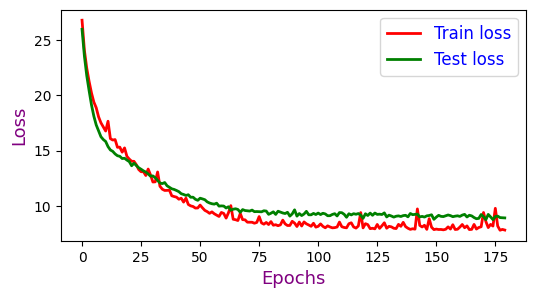

In [18]:
model_mpg = nn.Sequential(
            nn.Linear(9, 6),
            nn.ReLU(),
            nn.Linear(6, 3),
            nn.ReLU(),
            nn.Linear(3, 1))

torch.manual_seed(1)
nn.init.xavier_normal_(model_mpg[0].weight)
nn.init.xavier_normal_(model_mpg[2].weight)


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_mpg.parameters(), lr=0.001)


n_epochs = 200
n_train = len(y_train)
n_test = len(y_test)
# creates a list of length 'n_epochs' whose components are all equal to 0
loss_train = [0] * n_epochs
loss_test = [0] * n_epochs
for epoch in range(n_epochs):
    for x_batch, y_batch in train_dl:
        pred = model_mpg(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        # backpropagates to compute the gradients of the loss with respect to the model's parameters
        loss.backward()
        # updates the model's parameters using the computed gradients and the optimizer
        optimizer.step()
        # resets the gradients to None, preventing gradients from accumulating additively across
        # multiple iterations, which is the default behavior
        optimizer.zero_grad()
        # accumulates the loss for the current batch
        loss_train[epoch] += loss.item()
    loss_train[epoch] /= n_train/batch_size
    pred = model_mpg(x_test)[:, 0]
    loss = loss_fn(pred, y_test)
    loss_test[epoch] = loss.item()

print(BB + "train loss after 100 epochs :" + MB, round(loss_train[100],2))
print(BB + "test loss after 100 epochs :" + MB, round(loss_test[100],2))
print(BB + "train loss after 200 epochs :" + MB, round(loss_train[-1],2))
print(BB + "test loss after 200 epochs :" + MB, round(loss_test[-1],2))

fig = plt.figure(figsize=(6, 3))
plt.plot(loss_train[20:], lw=2, color="red")
plt.plot(loss_test[20:], lw=2, color="green")
plt.legend(['Train loss', 'Test loss'], fontsize=12, labelcolor="blue")
plt.xlabel('Epochs', size=13, color="purple")
plt.ylabel('Loss', size=13, color="purple")
plt.show()

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The losses converge quickly towards their final values. The overfitting is minimal. Although we use fewer units ($6$ instead of $8$ in the first hidden layer, and $3$ instead of $4$ in the second), our results are slightly better than the results of the book, with much less overfitting: our train loss is $7.83$ and our test loss is $8.92$, while the book has $6.22$ and $9.61$ respectively.<br>$\quad$
        Note that since the standard deviation on the target vector <font color='darkred'>y_train</font> is $7.67$, getting a result of $7.83$ - close to the standard deviation - indicates the model is capturing meaningful patterns and achieving a "good training result" by ChatGPT's standards. The standard deviation on the test dataset is $8.38$, and with an MSE of $8.92$, the model is performing well on the test data, suggesting it generalizes effectively.<br>$\quad$
        side-note : a model that would predict the mean of a dataset will get an MSE equal to the variance of the dataset

<a id="4"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>4. CLASSIFICATION PROJECT - THE MNIST DATASET</font></h4><br>$\quad$
        Following "3c. The various steps for building an ANN" we first import the dataset (which is the MNIST dataset), and create the Dataset and DataLoader :

In [19]:
# imports the torchvision library, which is a PyTorch package specifically designed for computer vision tasks.
# It provides prebuilt datasets, model architectures, and utilities for image preprocessing.
import torchvision
# imports the 'transforms' module from torchvision, which includes utilities for preprocessing and data
# augmentation (technique used in computer vision, to artificially increase the size and diversity of a
# training dataset by applying various transformations to the samples in order to create new variations,
# which improves the generalization and robustness of the model) of image datasets
from torchvision import transforms

# the dataset will be saved to and loaded from the current directory
image_path = './'
# creates a transform pipeline using 'transforms.Compose'; the pipeline converts images into PyTorch tensors
# using 'transforms.ToTensor()', while also scaling pixel values from [0, 255] to [0., 1.]
transform = transforms.Compose([transforms.ToTensor()])
# loads the MNIST training dataset : * 'root=image_path' specifies where the data will be stored
# * 'train=True' indicates that the training portion of the dataset is the one to load
# * 'transform=transform' applies the previous 'transform' pipeline
# * 'download=True' downloads the dataset if it is not already present at the specified path
mnist_train_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform,
                                                 download=True)
# loads the MNIST testing dataset : similar to the previous line, but with 'train=False' to load the test
# dataset instead of the training dataset
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform,
                                                download=True)
# defines the batch size for the DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Then we define our model. A MNIST image has a shape $[1, 28, 28]$ (1 channel - gray-scaled image -, and 28*28 pixels images); we first flatten the image into a sample with $784$ features (the pixels), then we use two layers with a linear preactivation and a ReLU activation, and finally the output layer is obtained from a linear preactivation without activation. The first hidden layer has $32$ units, the second layer has $16$ units, and the output layer has $10$ units (for the $10$ digits).<br>$\quad$
        As usual for multi-class classification problems, our loss function will be the <font color='green'>torch.nn.CrossEntropyLoss()</font> (defined in the previous part, "3c. The various steps for building an ANN", step 3).<br>$\quad$
        Our optimizer will be the <font color='green'>Adam</font> optimizer with a learning rate of $0.001$.<br>$\quad$
        For the training we will use the usual implementation, already used several times here. Since our task is a classification task, we can compute the loss and accuracy score at each epoch of the training. We use only $20$ epochs; using more improves the accuracy score on the training dataset, but worsens the accuracy score on the test dataset; with $20$ epochs we already have overfitting anyway. This time, I merely present the loss and the accuracy scores along these $20$ epochs, and after the training phase, I compute the accuracy score on the test dataset.<br>$\quad$
        The results are quite good, both on the training dataset (accuracy of $98.18\%$) and on the test dataset (accuracy of $96.49\%$).

In [20]:
model_mnist = nn.Sequential(
                nn.Flatten(),
                nn.Linear(784, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 10))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mnist.parameters(), lr=0.001)
n_train = len(mnist_train_dataset)

n_epochs = 20
for epoch in range(n_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model_mnist(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
    accuracy_hist_train /= n_train
    # '.item()' converts a single-element tensor into a Python scalar, which is needed to use 'round'
    print(BB + "Epoch :" + MB, epoch,
          BB + "; Train loss :" + MB, round(loss.item(), 4),
          BB + "; Train accuracy :" + MB, round(accuracy_hist_train.item(), 4))

# 'mnist_test_dataset.data' and 'mnist_test_dataset.targets' are the test dataset matrix and its target vector
pred = model_mnist(mnist_test_dataset.data / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(BB + "\nTest accuracy :" + MB, round(is_correct.mean().item(), 4))

Epoch : 0 ; Train loss : 0.0751 ; Train accuracy : 0.8514
Epoch : 1 ; Train loss : 0.1375 ; Train accuracy : 0.9287
Epoch : 2 ; Train loss : 0.0479 ; Train accuracy : 0.9422
Epoch : 3 ; Train loss : 0.1392 ; Train accuracy : 0.9492
Epoch : 4 ; Train loss : 0.1788 ; Train accuracy : 0.9538
Epoch : 5 ; Train loss : 0.0575 ; Train accuracy : 0.9584
Epoch : 6 ; Train loss : 0.0889 ; Train accuracy : 0.9622
Epoch : 7 ; Train loss : 0.208 ; Train accuracy : 0.9647
Epoch : 8 ; Train loss : 0.1495 ; Train accuracy : 0.9673
Epoch : 9 ; Train loss : 0.0433 ; Train accuracy : 0.9687
Epoch : 10 ; Train loss : 0.0528 ; Train accuracy : 0.971
Epoch : 11 ; Train loss : 0.0115 ; Train accuracy : 0.9722
Epoch : 12 ; Train loss : 0.0735 ; Train accuracy : 0.9736
Epoch : 13 ; Train loss : 0.0907 ; Train accuracy : 0.975
Epoch : 14 ; Train loss : 0.0201 ; Train accuracy : 0.9766
Epoch : 15 ; Train loss : 0.0432 ; Train accuracy : 0.9781
Epoch : 16 ; Train loss : 0.0218 ; Train accuracy : 0.9789
Epoch : 17

<br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h2 style="margin: 0 0 1rem 2rem; font-size: 20px; font-weight: 900"><font color='darkpink'>Appendix - PYTORCH LIGHTNING</font><a id="Appendix"></a></h2>
    <br><strong><font color='darkblue'><span style="font-size: 17px; margin-right: 5px; vertical-align: center;">$\qquad$■</span></font><font color='purple'>1. What is PyTorch Lightning ?</font></strong><font color='darkblue'><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    <font color='darkpink'>PyTorch Lightning</font>, or <font color='darkpink'>Lightning</font> for short, is a high-level framework built on top of PyTorch that simplifies the process of training deep learning models. While PyTorch provides the flexibility to build and train models, it requires developers to manually handle many aspects of the training process, such as writing the training loop, managing optimizer steps, handling distributed training, and saving checkpoints. PyTorch Lightning automates these tasks, allowing developers to focus on defining the model architecture rather than dealing with the lower-level details of training.<br>$\quad$
        PyTorch Lightning simplifies integration with various tools for logging, visualization, and experiment tracking. These tools are often essential for managing and optimizing machine learning workflows, and Lightning reduces the need for manual setup. Furthermore, by organizing the training process into standardized methods and separating concerns (such as data loading, forward pass, and evaluation), it makes code more readable, maintainable, and less error-prone.<br>$\quad$
        One key feature of PyTorch Lightning is its ability to handle checkpointing (the process of saving the model’s state during training, including weights and optimizer state). This ensures that training can be resumed later from a specific point, which is especially useful in case of interruptions or when trying different configurations without losing progress. Additionally, PyTorch Lightning provides built-in support for distributed training across multiple GPUs, making it easier to scale models without needing to write complex code for parallel processing.<br>$\quad$
        PyTorch provides more control, which is great for experimentation and research, so it is often favored by researchers or individuals working on custom models. In contrast, Lightning simplifies the training process by automating tasks and removing boilerplate code, improving development efficiency, while still relying on PyTorch for the underlying computations. PyTorch is great for individual research and prototyping, while Lightning is used at the production stage to simplify working on larger datasets, in team and with multiple GPUs.

<br><strong><font color='darkblue'><span style="font-size: 17px; margin-right: 5px; vertical-align: center;">$\qquad$■</span></font><font color='purple'>2. Downloading, preparing and splitting the dataset</font></strong><font color='darkblue'><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In this appendix, we are going to study the MNIST dataset with PyTorch Lightning. We use a subclass of <font color='green'>LightningDataModule</font> to download and prepare our dataset, so it can be used by Lightning. The first step is to initialize the dataset (say where to find it and convert it into PyTorch tensors); then we can prepare (mainly download) it; set it up, ie mainly split it into various sub-datasets (eg a training, a validation and a test datasets); and define a DataLoader for each. <font color='darkpink'>The methods to do so are always named the same</font> (keynames) :

In [21]:
# imports the MNIST dataset class from torchvision for easy access to MNIST data
from torchvision.datasets import MNIST
# imports 'LightningDataModule' to manage data loading, preprocessing, and splitting in PyTorch Lightning
from pytorch_lightning import LightningDataModule
# imports 'transforms' from torchvision, used for image preprocessing and transformation
from torchvision import transforms
# imports 'random_split' to split datasets into subsets (train, validation, test)
from torch.utils.data import random_split
# imports 'DataLoader' to handle data loading and batching
from torch.utils.data import DataLoader

# defines a custom PyTorch Lightning DataModule for the MNIST dataset
class MnistDataModule(LightningDataModule):
    # initializes the DataModule with an optional data_path argument (defaults to the current directory)
    def __init__(self, data_path="./"):
        # calls the constructor of the parent LightningDataModule class
        super().__init__()
        # stores the path where the MNIST dataset will be saved or loaded from
        self.data_path = data_path
        # defines a simple pipeline, which merely converts images to tensors (it is identical to the one we
        # used in cell 19 within a code for PyTorch - not Lightning -)
        self.transform = transforms.Compose([transforms.ToTensor()])

    # prepares the data (here merely downloads the dataset if not already present)
    def prepare_data(self):
        # downloads the MNIST dataset and stores it at the specified data_path
        MNIST(root=self.data_path, download=True)
    
    # splits the data into training, validation, and test sets
    # 'stage' can be 'fit', 'predict', 'validate', or 'test' according to the specific stage of training
    # or testing
    def setup(self, stage=None):
        # loads the full MNIST training dataset, applying the conversion 'transform' defined earlier
        mnist_all = MNIST(root=self.data_path, train=True, transform=self.transform, download=False)
        # splits the MNIST training set into a training and a validation set
        self.train, self.val = random_split(mnist_all, [55000, 5000],
                                            generator=torch.Generator().manual_seed(1))
        # loads the MNIST test dataset, applying the same conversion
        self.test = MNIST(root=self.data_path, train=False, transform=self.transform, download=False)
    
    # returns a DataLoader for the training set, which handles batching and data loading with 4 workers, ie
    # independent processing units which work in parallel to speed up the data loading and processing pipeline
    # 'persistent_workers=True' specifies that they should not be terminated and respawned at the end of each
    # epoch (which is the default); this makes the pipeline faster at the cost of some memory between epochs
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64, num_workers=4, persistent_workers=True)
    
    # returns a DataLoader for the validation set, similar to the training DataLoader
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64, num_workers=4, persistent_workers=True)
    
    # returns a DataLoader for the test set, similar to the training DataLoader
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64, num_workers=4, persistent_workers=True)

<br><br><strong><font color='darkblue'><span style="font-size: 17px; margin-right: 5px; vertical-align: center;">$\qquad$■</span></font><font color='purple'>3. Writing the PyTorch Lightning model</font></strong><font color='darkblue'><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The second step is to define the model. In Lightning the model and its layers are not subclasses of PyTorch <font color='green'>Module</font>, but of PyTorch Lightning <font color='green'>LightningModule</font>. As a subclass of <font color='green'>LightningModule</font> it possesses methods with keynames, called <font color='darkpink'>hooks</font>, for specifying the optimizer (<font color='darkpink'>configure_optimizers</font>), computing the forward pass (<font color='darkpink'>forward</font>), training the model with the declaration of the loss function (<font color='darkpink'>training_step</font>), logging the results (<font color='darkpink'>on_train_epoch_end</font>), and testing the model, eg with the accuracy scores (<font color='darkpink'>validation_step</font> and <font color='darkpink'>test_step</font>) :

In [22]:
# imports PyTorch core functionality (torch) and its neural network module (nn) for defining layers and models
import torch
import torch.nn as nn
# imports 'LightningModule' for defining and training models in PyTorch Lightning
from pytorch_lightning import LightningModule
# imports the Accuracy class from torchmetrics (which is independant from PyTorch and Lightning) to measure
# classification accuracy during training, validation, and testing
from torchmetrics import Accuracy

# defines a Lightning module which inherits from 'pl.LightningModule' and encapsulates the entire workflow
class MultiLayerPerceptron(LightningModule):
    # initializes the model
    def __init__(self, image_shape=(1, 28, 28), hidden_units=(32, 16)):
        # calls the parent class (LightningModule) constructor to initialize its attributes and functionality
        super().__init__()
        # defines accuracy metrics for training, validation, and testing for a 10-class classification problem
        self.train_acc = Accuracy(task='multiclass', num_classes=10)
        self.valid_acc = Accuracy(task='multiclass', num_classes=10)
        self.test_acc = Accuracy(task='multiclass', num_classes=10)

        # calculates the flattened input size for the images (784 for the MNIST)
        input_size = image_shape[0] * image_shape[1] * image_shape[2]
        # builds the ANN
        self.model_mnist2 = nn.Sequential(
                                nn.Flatten(),
                                nn.Linear(input_size, hidden_units[0]),
                                nn.ReLU(),
                                nn.Linear(hidden_units[0], hidden_units[1]),
                                nn.ReLU(),
                                nn.Linear(hidden_units[1], 10))

    # defines the forward pass of the model by applying the model_mnist2 pipeline to the input x
    def forward(self, x):
        return self.model_mnist2(x)

    # configures the optimizer for the model, using the Adam optimizer with a learning rate of 0.001
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    # defines a single training step
    def training_step(self, batch, batch_idx):
        # unpacks the input batch into features (x) and labels (y)
        x, y = batch
        # feeds 'x' into the model to get the raw predictions (logits)
        logits = self(x)
        # computes the cross-entropy loss between the predictions (logits) and the true labels (y)
        loss = nn.functional.cross_entropy(logits, y)
        # converts the logits into class predictions by taking the index of the maximum value along the rows
        # (the instances and their images in the layers are in rows in PyTorch and Lightning)
        preds = torch.argmax(logits, dim=1)
        # updates the training accuracy with the current batch’s predictions and their true labels
        self.train_acc.update(preds, y)
        # logs the training loss for this batch and displays it in the progress bar
        self.log("train_loss", loss, prog_bar=True)
        # returns the loss for backpropagation (Lightning will perform backpropagation from the loss returned
        # by the method named 'training_step')
        return loss
    
    def on_train_epoch_end(self):
        # at the end of a training epoch, computes and logs the corresponding training accuracy
        self.log("train_acc", self.train_acc.compute(), prog_bar=True)
        # resets the metric to avoid carry-over to the next epoch
        self.train_acc.reset()

    # defines the validation step, similar to the training_step but without backpropagation (Lightning will
    # not perform backpropagation from the loss returned by the method named 'validation_step')
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc.update(preds, y)
        # Log loss during the validation step
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # Compute and log total loss and accuracy at the end of the epoch
    def on_validation_epoch_end(self):
        # 'self.trainer' is the Lightning Trainer object that manages training, validation, and testing
        # it stores all the metrics in a dictionary, called 'callback_metrics'
        # the mean of the losses can be found under the key "val_loss"
        # it is already logged in at the end of each epoch when calling 'validation_step', so it's useless
        # here, and only serves the purpose of showing a possible use of 'self.trainer'
        total_loss = self.trainer.callback_metrics["val_loss"]
        # 'self.log()' is a Lightning method used to log any scalar values (like metrics or losses) during
        # training, validation, or testing
        # 'prog_bar=True' specifies that this value should be displayed in the progress bar
        self.log("valid_loss", total_loss, prog_bar=True)
        # at the end of a training epoch, computes and logs the corresponding training accuracy
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
        # resets the metric to avoid carry-over to the next epoch
        self.valid_acc.reset()

    # defines the test step, structured similarly to the validation step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        # Log loss during the validation step
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    # computes and logs the total loss and the accuracy score at the end of the epoch
    def on_test_epoch_end(self):
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        self.test_acc.reset()

<br><br><strong><font color='darkblue'><span style="font-size: 17px; margin-right: 5px; vertical-align: center;">$\qquad$■</span></font><font color='purple'>4. Evaluate the PyTorch Lightning model</font></strong><font color='darkblue'><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In order to compare the results obtained with Lightning to those obtained with PyTorch (in the previous code, "4. Classification project - The MNIST dataset"), we've used the same optimizer (Adam), with the same learning rate ($0.001$), the same batch size ($64$), and the same random seed <font color='darkred'>torch.manual_seed(1)</font>).<br>$\quad$
        The results logged during the training phase show a slightly better fit to the training dataset with Lightning, all along (eg an accuracy score of $97.1\%$ instead of $96.9\%$ after $10$ epochs, and of $98.3\%$ instead of $98.2\%$ after $20$ epochs); but a priori more overfitting, with a validation accuracy of $95.2\%$ to compare to the test accuracy of $96.5\%$ with the PyTorch methods.

In [23]:
# imports 'Trainer' to handle the training and evaluation loop in PyTorch Lightning, automating tasks like
# gradient descent and logging
from pytorch_lightning import Trainer

# sets PyTorch seed to 1 (the same as in our PyTorch code)
torch.manual_seed(1)
# creates the data module
mnist_dm = MnistDataModule()

# creates the model
mnistclassifier = MultiLayerPerceptron()

# initializes the trainer
if torch.cuda.is_available():
    # 'devices' is the number of GPUs available
    # one may add the argument 'strategy="ddp"' to use the DistributedDataParallel strategy
    trainer = Trainer(devices=1, accelerator="gpu", max_epochs=20)
else:
    trainer = Trainer(accelerator="cpu", max_epochs=20)

# fits the model
trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | train_acc    | MulticlassAccuracy | 0      | train
1 | valid_acc    | MulticlassAccuracy | 0      | train
2 | test_acc     | MulticlassAccuracy | 0      | train
3 | model_mnist2 | Sequential         | 25.8 K | train
------------------------------------------------------------
25.8 K    Trainable params
0         Non-trainable params
25.8 K    Total params
0.103     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Another nice feature of Lightning is its logging capabilities. Recall that we specified several <font color='darkred'>self.log</font> steps in our Lightning model earlier; we've just used them to display the progress during training. But after, and even during training, we can visualize them in <font color='darkpink'>TensorBoard</font>. TensorBoard was originally developed as part of the TensorFlow ecosystem, but is now compatible with other frameworks like PyTorch<br>$\quad$
        By default, Lightning tracks the training in a subfolder named <font color='green'>lightning_logs</font>. To visualize the training runs, we do :

In [24]:
import os
from tensorboard import program
from IPython.display import IFrame

# Specify the log directory
logdir = './lightning_logs/'

# Start TensorBoard programmatically
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', logdir])
url = tb.launch()
print(f'TensorBoard is running at: {url}')

# You can display the TensorBoard UI within the notebook
IFrame('http://localhost:6006', width=800, height=600)

TensorBoard is running at: http://localhost:6006/


<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Lightning stores the individual training runs in subfolders, themselves stored in a directory called <font color='darkred'>lightning_logs</font>, itself placed in the same directory as our notebook. The subfolder corresponding to the $n$-th training is called <font color='darkred'>version $n$</font>. Inside <font color='darkred'>version $n$</font> we can find the subfolder called <font color='darkred'>checkpoints</font>, which holds the file with the results of our $n$-th training session. It is possible to load these results and continue the training from where we left it at. For example, if we want to train our model for $5$ more epochs (ie for a total of $25$ epochs; the accuracy score on the training dataset will slightly improve - to $98.6\%$ -, but the predictions won't - if anything they become slightly worse -), we do :

In [25]:
# the local address of the file we want to continue training from, eg here :
current_file = "./lightning_logs/version_10/checkpoints/epoch=19-step=17200.ckpt"

if torch.cuda.is_available():
    trainer = Trainer(devices=1, accelerator="gpu", max_epochs=25)
else:
    trainer = Trainer(accelerator="cpu", max_epochs=25)

trainer.fit(model=mnistclassifier, datamodule=mnist_dm, ckpt_path=current_file)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./lightning_logs/version_10/checkpoints/epoch=19-step=17200.ckpt
D:\Tools\Python 3.12.3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:362: The dirpath has changed from 'C:\\Users\\arslu\\Desktop\\Learning IT\\AI\\2. Algorithms\\Machine learning with Pytorch and Scikit-Learn\\13. The mechanics of PyTorch\\lightning_logs\\version_10\\checkpoints' to 'C:\\Users\\arslu\\Desktop\\Learning IT\\AI\\2. Algorithms\\Machine learning with Pytorch and Scikit-Learn\\13. The mechanics of PyTorch\\lightning_logs\\version_16\\checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | train_acc

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=25` reached.


<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Once we are finished with training, we can evaluate the model on the test set using the following code (the results are slightly worse as they were with PyTorch alone, with a test accuracy of $95.69\%$ instead of $96.49\%$) :

In [26]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm)

Testing: |                                                                                                    …

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9569000005722046
        test_loss           0.17440609633922577
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.17440609633922577, 'test_acc': 0.9569000005722046}]

<br><p style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Note that Lightning also saves the model automatically for us. If we want to reuse the model
later, we can conveniently load it via the code :<br>$\quad$<font color='darkred'>
        model = MultiLayerPerceptron.load_from_checkpoint("path/to/checkpoint.ckpt")</font>